- 레스토랑 리뷰 감성 분류하기 :
https://github.com/rickiepark/nlp-with-pytorch/blob/main/chapter_3/3_5_Classifying_Yelp_Review_Sentiment.ipynb

- NLP using GloVe Embeddings(FAKE NEWS) : 
https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy
- https://www.kaggle.com/code/lorwohl/fake-news-detection

In [1]:
# 모듈 로딩
import numpy as np
import pandas as pd
import re
import string
from string import punctuation

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.stem import WordNetLemmatizer # 표제어 추출

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer # used to tokenize text sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding sequences to the same length
from tensorflow.keras.models import Sequential # building sequential models like FF layers in the transformer encoder
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Dropout # used for parts of the transformer encoder

---
### [1] 데이터 보기 및 시각화

In [2]:
real = pd.read_csv("./True.csv")
fake = pd.read_csv("./Fake.csv")

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# real / fake에 범주 부여
fake['category']=0
real['category']=1

In [6]:
# real / fake 합치기
df=pd.concat([real, fake])

0    23481
1    21417
Name: category, dtype: int64
RealNEws : 0.52%
FakeNews : 0.48%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

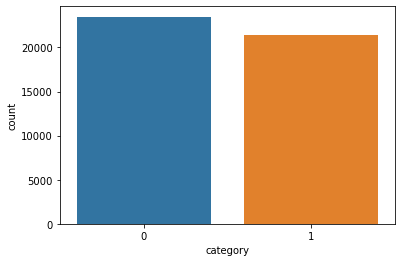

In [7]:
# 카테고리 확인
print(df.category.value_counts())
print(f'RealNEws : {round(df.category.value_counts()[0] / df.category.count(), 2)}%')
print(f'FakeNews : {round(df.category.value_counts()[1] / df.category.count(), 2)}%')

# sns.countplot => 갯수 확인 시각화
sns.countplot(df.category)

In [8]:
# 중복 제거
df.duplicated().sum()

209

In [9]:
# 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [10]:
# 결측치 확인
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [11]:
# 형태 확인
df.shape

(44898, 5)

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


<AxesSubplot:xlabel='subject', ylabel='count'>

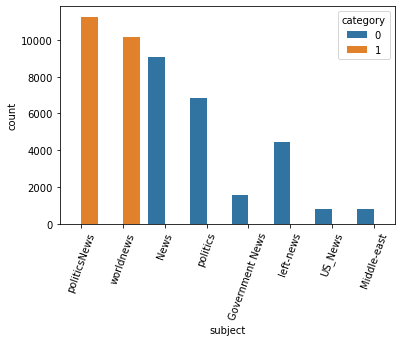

In [12]:
# 뉴스의 종류 확인
print(df.subject.value_counts())

# 카테고리 별 뉴스 종류 확인
plt.xticks(rotation=70)
sns.countplot(x='subject', hue='category', data=df)

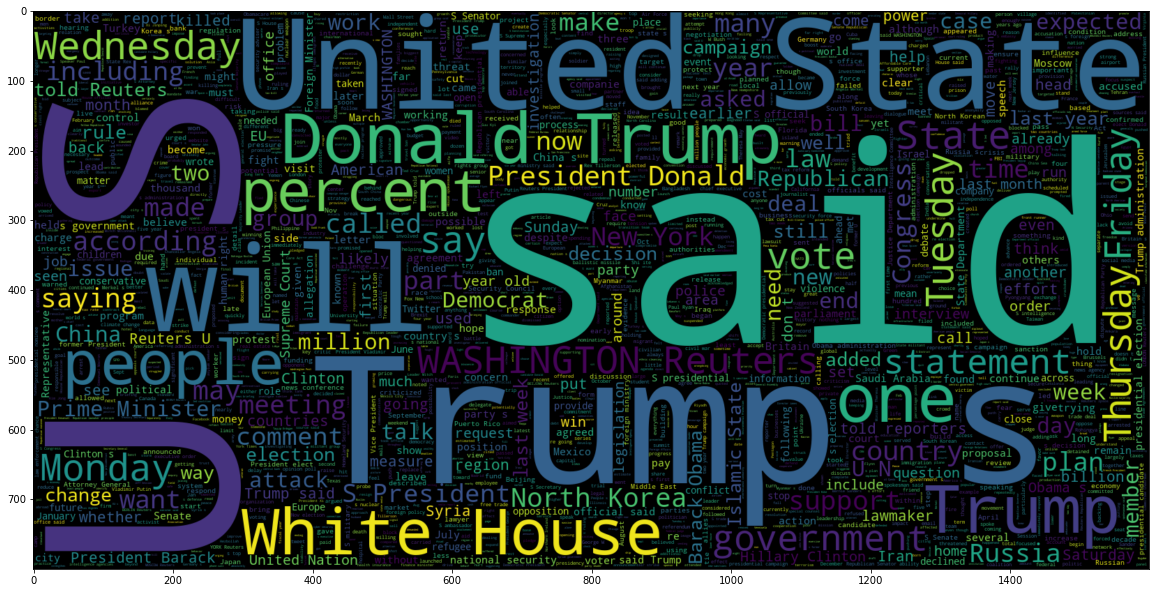

In [13]:
# Real News
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

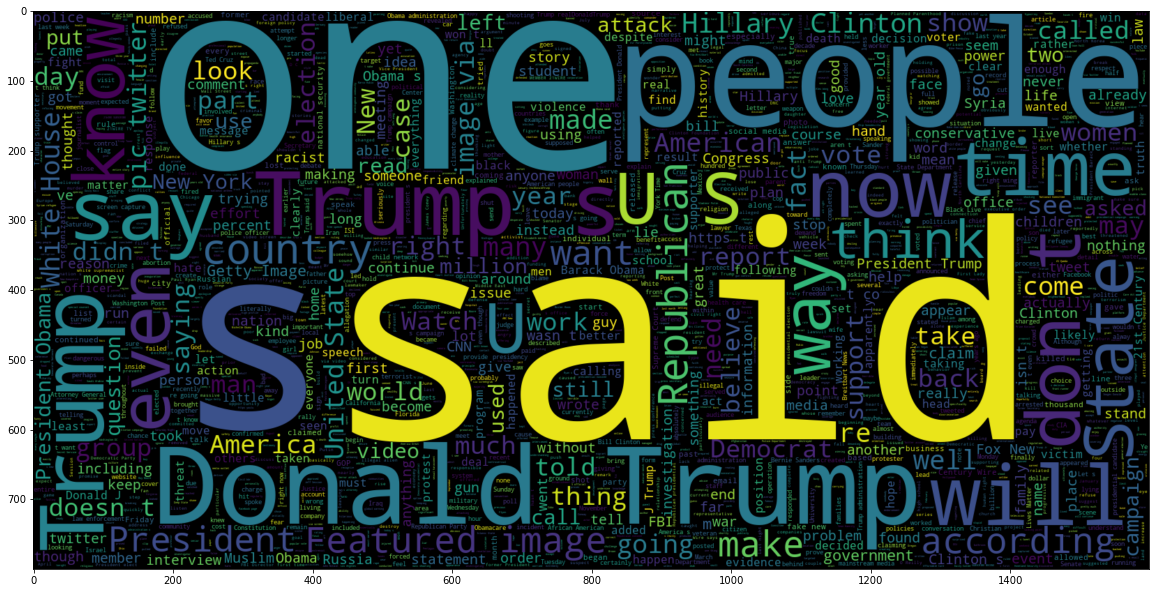

In [14]:
# Fake News
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

---
## [2] 데이터 처리

In [15]:
# 뉴스 기사들을 한 컬럼으로 합치기
df['text_all']=df['text'] + ' ' + df['title']
df['text_all'].head()

del df['title']
del df['subject']
del df['date']

### 데이터 분할

In [16]:
# from sklearn.model_selection import train_test_split, 비율에 맞게 분할
X_train, X_test, y_train, y_test = train_test_split(df.text_all, 
                                                    df.category, 
                                                    test_size=0.2, 
                                                    stratify=df.category,
                                                    random_state=11)

print(f'X_train : {X_train.shape}, X_test : {X_test.shape}')

X_train : (35918,), X_test : (8980,)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=11)
print(f'X_train : {X_train.shape}, X_test : {X_test.shape} , X_val : {X_val.shape}')

X_train : (28734,), X_test : (8980,) , X_val : (7184,)


In [18]:
print('\n', '학습 데이터', '-'*20)
print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'가짜뉴스 : {round(y_train.value_counts()[0]/len(y_train),2)}%')
print(f'진짜뉴스 : {round(y_train.value_counts()[1]/len(y_train),2)}%')

print('\n', '테스트 데이터', '-'*20)
print(f'X_test   : {X_test.shape}, y_test : {y_test.shape}')
print(f'가짜뉴스 : {round(y_test.value_counts()[0]/len(y_test),2)}%')
print(f'진짜뉴스 : {round(y_test.value_counts()[1]/len(y_test),2)}%')

print('\n', '검증 데이터', '-'*20)
print(f'X_val    : {X_val.shape}, y_val : {y_val.shape}')
print(f'가짜뉴스 : {round(y_val.value_counts()[0]/len(y_val),2)}%')
print(f'진짜뉴스 : {round(y_val.value_counts()[1]/len(y_val),2)}%')


 학습 데이터 --------------------
X_train : (28734,), y_train : (28734,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%

 테스트 데이터 --------------------
X_test   : (8980,), y_test : (8980,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%

 검증 데이터 --------------------
X_val    : (7184,), y_val : (7184,)
가짜뉴스 : 0.52%
진짜뉴스 : 0.48%


### 불용어 처리
string.punctuation -> !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [19]:
from wordcloud import WordCloud #, STOPWORDS # wordcloud 모듈에도 stopword 기능 있음?
from nltk.corpus import stopwords

# stop=set(stopwords.words('english'))
stopwords=set(nltk.corpus.stopwords.words('english'))
# punctuation = string.punctuation
# stop.update(punctuation)

### 텍스트 데이터 전처리

In [20]:
# 텍스트 처리하는 함수
def textProcess(textData):
    refined_texts = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    w_tokens = word_tokenize(textData) # 단어_토큰화
    for w in w_tokens:
        
        if w not in stop: # english stopwords에 포함 안되어있다면 ~ 해라
            refined_t = re.sub('[^a-zA-Z]', '', w)
            refined_t = refined_t.lower() # 소문자로
            
            # 표제어 추출
            refined_t = wordnet_lemmatizer.lemmatize(w)
            refined_texts.append(refined_t)
    
    return " ".join(refined_texts) # 단어에서 문장으로 복원

In [21]:
# refined_data = []
# for i in df.text_all:
#     refined_data.append(textProcess(i))
    
X_train = [textProcess(i) for i in X_train]
X_test = [textProcess(i) for i in X_test]
X_val = [textProcess(i) for i in X_val]

In [22]:
X_train[:1]

['a group white lives matter protestors held protest outside building houston chapter naacp sunday morning members group indicated angry naacp spoken black lives matter movement we came protest naacp failure speaking atrocities organizations like black lives matter pro-black organizations caused attack killing white police officers burning cities things nature member white lives matter group said if going civil rights organization defend people also need hold people accountable during protest protestors carried assault rifles firearms well giant confederate flag we instigate start problems reed said obviously exercising second amendment rights defend their organizations people shooting people based color skin we we definitely defend start problems we came naacp headquarters one racist groups america protestor named scott lacey said.police eventually arrived protest created barricade no one harmed protest except anyone still ounce left faith humanity.you watch video report protest below

### 텍스트 데이터 토큰화 및 수치화

In [60]:
# 텍스트 데이터 토큰화한 후 수치화
def makeToken(textData):
    myToken=Tokenizer(num_words=300)
    
    # 단어사전(voca) 생성
    myToken.fit_on_texts(textData)
    seq_Token = myToken.texts_to_sequences(textData)
    
    return (seq_Token, voca_w_num)

In [ ]:
    # voca 총개수
    voca_w_num = len(myToken.word_index)
    print(f'voca_w_num => {voca_w_num}')

In [24]:
X_train, X_train_vocaNum = makeToken(X_train)
X_test, X_test_vocaNum = makeToken(X_test)
X_val, X_val_vocaNum = makeToken(X_val)

In [61]:
print(f'X_train_vocaNum => {X_train_vocaNum} | X_test_vocaNum => {X_test_vocaNum} | X_val_vocaNum => {X_val_vocaNum} ')

X_train_vocaNum => 104528 | X_test_vocaNum => 63247 | X_val_vocaNum => 55955 


### 단어 갯수 파악

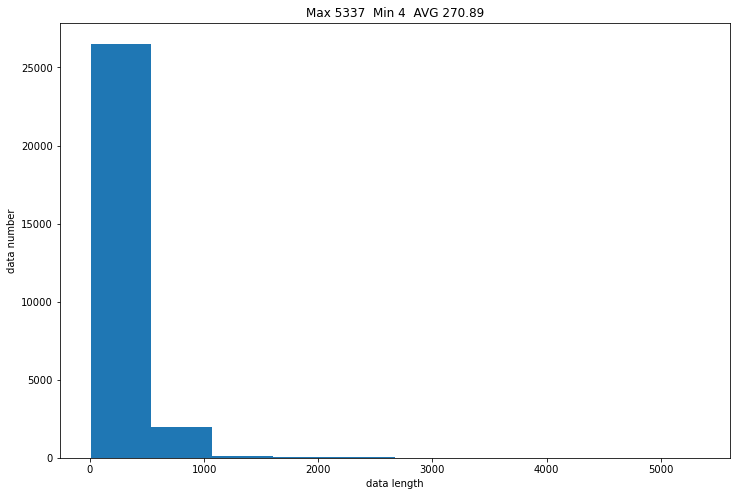

In [25]:
# # 단어 갯수 파악 함수
# def checkLength(datas):

#   # 기사 개당 단어 개수
#   length=[len(data) for data in datas]
  
#   # 히스토그램
#   plt.figure(figsize=(12,8))
#   plt.hist(length)
#   plt.title(f'Max {max(length)}  Min {min(length)}  AVG {round(sum(length)/len(length),2)}')
#   plt.xlabel('data length')
#   plt.ylabel('data number')
#   plt.show()
# # return length
  
# checkLength(X_train)  

In [72]:
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

# text_len=df[df['category']==1]['text_all'].str.len()
# ax1.hist(text_len,color='red')
# ax1.set_title('Real text')

# text_len=df[df['category']==0]['text_all'].str.len()
# ax2.hist(text_len,color='green')
# ax2.set_title('Fake text')

# fig.suptitle('Characters in texts')
# plt.show()

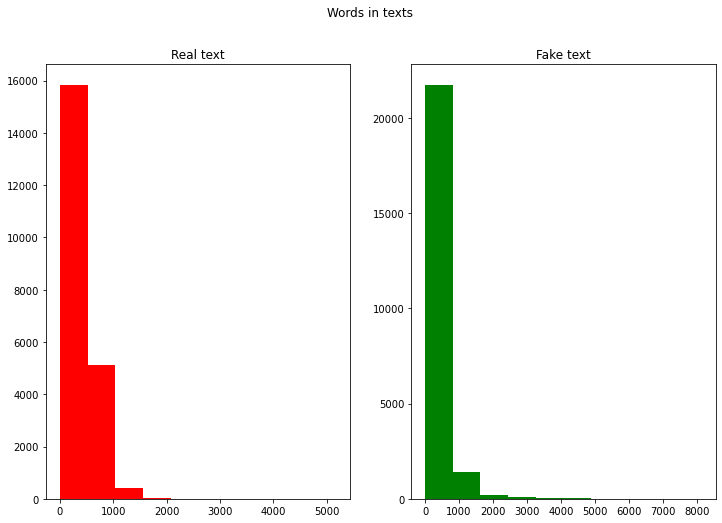

In [71]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text_all'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Real text')
text_len=df[df['category']==0]['text_all'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

### pad_sequences

In [28]:
maxlen = 300
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [51]:
X_train.shape, X_test.shape, X_val.shape

((28734, 300), (8980, 300), (7184, 300))

In [52]:
type(X_val), X_val[:5]`

(numpy.ndarray,
 array([[ 9429, 34502, 34503, ...,     3,     6,     9],
        [    0,     0,     0, ...,  1262,  1134,   843],
        [  653,   201,  6251, ...,  2962,     7,    52],
        [    0,    16,  1324, ...,    91,   160,    44],
        [    0,     0,     0, ...,  1303,  7458, 11095]]))

---
## 모델 구성
https://jimmy-ai.tistory.com/281

In [81]:
EMB_DIM = 16                     # 임베딩 벡터 크기 
WORD_NUM = X_train_vocaNum         # 단어사전 수
HIDDEN_NODE = 64                # 은닉층 뉴런 수
INPUT_LENGTH = 300         # 1문장의 토큰 수 

In [82]:
model = Sequential()
# RNN 적용을 위한 임베딩 지정
model.add(Embedding(WORD_NUM+1, EMB_DIM, input_length=INPUT_LENGTH))

### RNN 파트 시작점 ###

# 이중층 GRU -> SimpleRNN, 단일 방향 예시
model.add(GRU(HIDDEN_NODE, return_sequences=True))
model.add(SimpleRNN(HIDDEN_NODE))

### RNN 파트 끝점 ###

# fc layer 부분(32 차원 변환 -> dropout -> 이진 분류 결과)
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid')) # 이진 분류를 위한 마지막 layer 설정

In [83]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 32)           3344928   
                                                                 
 gru_4 (GRU)                 (None, 300, 64)           18816     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,374,113
Trainable params: 3,374,113
No

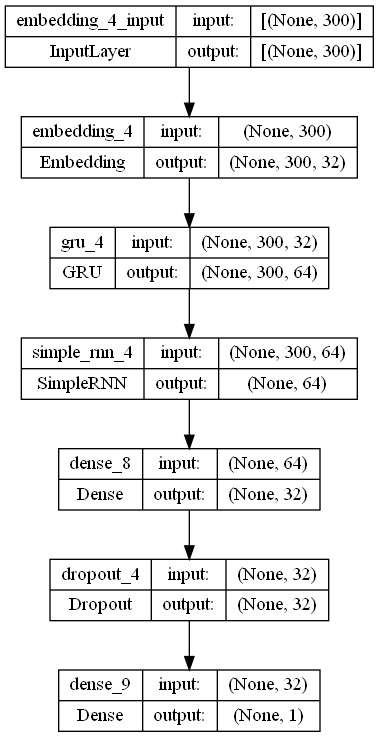

In [84]:
plot_model(model, show_shapes=True)

## 모델 생성

In [85]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 모델 학습

In [86]:
Batch_size = 32
Epochs = 5

In [87]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience = 2, 
#                                             verbose=1,
#                                             factor=0.5, 
#                                             min_lr=0.00001)

In [89]:
history = model.fit(X_train, y_train, epochs = Epochs, 
                    batch_size = Batch_size, validation_data = (X_val, y_val))

Epoch 1/10
898/898 [==============================] - 145s 159ms/step - loss: 0.0945 - accuracy: 0.9496 - val_loss: 1.6623 - val_accuracy: 0.6996
Epoch 2/10
702/898 [======================>.......] - ETA: 29s - loss: 0.0036 - accuracy: 0.9989

KeyboardInterrupt: 

### 모델 평가

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(20, 8))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend(fontsize=10)
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)